<a href="https://colab.research.google.com/github/matheuscassolc/datasciencepucpr/blob/main/credit_default_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Análise de Inadimplência de Crédito**

## **Estudantes**
- Matheus Henrique Cassol Cruz
- André Guimarães Galli
- João Vitor Henriques Greghi
- Leonardo dos Santos Fonseca Patruni
- Pedro Tavares
- Thomaz Rodrigues dos Santos

## **Introdução**

Neste projeto, trabalhamos com uma base de dados composta por informações demográficas, econômicas e comportamentais de indivíduos.
Nosso objetivo principal é entender os fatores que influenciam a probabilidade de inadimplência de um cliente, ou seja, a chance de que ele não quite integralmente sua dívida.

A variável alvo da análise é o TARGET, onde 0 indica clientes que quitaram suas dívidas normalmente e 1 representa aqueles que entraram em inadimplência.
A partir das variáveis disponíveis, conduzimos análises exploratórias para investigar padrões, relações e possíveis preditores de risco de crédito.

## **Tecnologia e definições**

Neste projeto, optamos por utilizar o Apache Spark para o processamento dos dados devido à sua capacidade de realizar operações de forma paralela e distribuída, garantindo alta performance mesmo em volumes de dados expressivos.
Além disso, o Spark nos permite trabalhar diretamente com SQL, o que traz grande flexibilidade para a exploração dos dados e facilita tanto a modelagem analítica quanto a replicação de consultas em ambientes de produção.

As análises foram majoritariamente feitas utilizando consultas SQL, por serem mais intuitivas para a formulação de hipóteses e por possibilitarem uma transição mais simples para bases de dados relacionais no futuro, caso necessário.


# **Pré Tratamento e Preparação**

Antes de iniciar as análises, realizamos um pré-tratamento dos dados: valores iguais a -9999 (utilizados para representar dados ausentes na base original) foram substituídos por nulos (NULL). Essa substituição foi fundamental para garantir a correção nos cálculos estatísticos e evitar distorções em médias, medianas e distribuições geradas durante a análise exploratória.

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
from pyspark.sql.functions import col, when

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
spark = SparkSession.builder.appName("credit_default_analysis").getOrCreate()

In [10]:
DATA_SOURCE_PATH = "/content/credit/train.csv"

df = spark.read.csv(DATA_SOURCE_PATH, header=True, inferSchema=True).cache()

df = df.select([
    when(col(c) == -9999, None).otherwise(col(c)).alias(c)
    for c in df.columns
])

df.createOrReplaceTempView("train")

In [11]:
def query(sql: str, n: int = 20) -> DataFrame:
  return spark.sql(sql).show(n)

# **Análises Univariadas em Relação ao Risco de Default**

## **Clientes com renda mais baixa têm maior probabilidade de inadimplência?**

+------+-------------+-----------------+----------+----------+
|TARGET|total_clients|       avg_income|min_income|max_income|
+------+-------------+-----------------+----------+----------+
|   0.0|        82425|3184.619957537155|       400|     30000|
|   1.0|         8462|2184.826282202789|       400|     30000|
+------+-------------+-----------------+----------+----------+



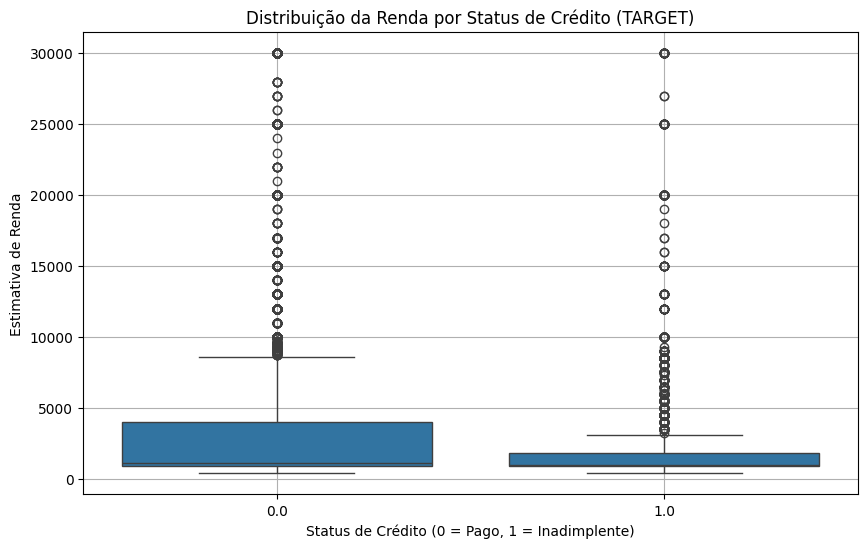

In [12]:
query("""
SELECT
  TARGET,
  COUNT(*) AS total_clients,
  AVG(ESTIMATIVARENDA) AS avg_income,
  MIN(ESTIMATIVARENDA) AS min_income,
  MAX(ESTIMATIVARENDA) AS max_income
FROM train
WHERE ESTIMATIVARENDA IS NOT NULL
GROUP BY TARGET
ORDER BY TARGET
""")

income_target_data = spark.sql("""
SELECT
  TARGET,
  ESTIMATIVARENDA
FROM train
WHERE ESTIMATIVARENDA IS NOT NULL
""").toPandas()

plt.figure(figsize=(10,6))
sns.boxplot(x="TARGET", y="ESTIMATIVARENDA", data=income_target_data)
plt.title('Distribuição da Renda por Status de Crédito (TARGET)')
plt.xlabel('Status de Crédito (0 = Pago, 1 = Inadimplente)')
plt.ylabel('Estimativa de Renda')
plt.grid(True)
plt.show()

## **O número de pessoas na casa (QTDPESSOASCASA) influencia a probabilidade de inadimplência?**

+------+-------------+------------------+------------------+------------------+
|TARGET|total_clients|avg_household_size|min_household_size|max_household_size|
+------+-------------+------------------+------------------+------------------+
|   0.0|        31839|2.9818461635101605|                 2|                10|
|   1.0|         3088|3.1531735751295336|                 2|                10|
+------+-------------+------------------+------------------+------------------+



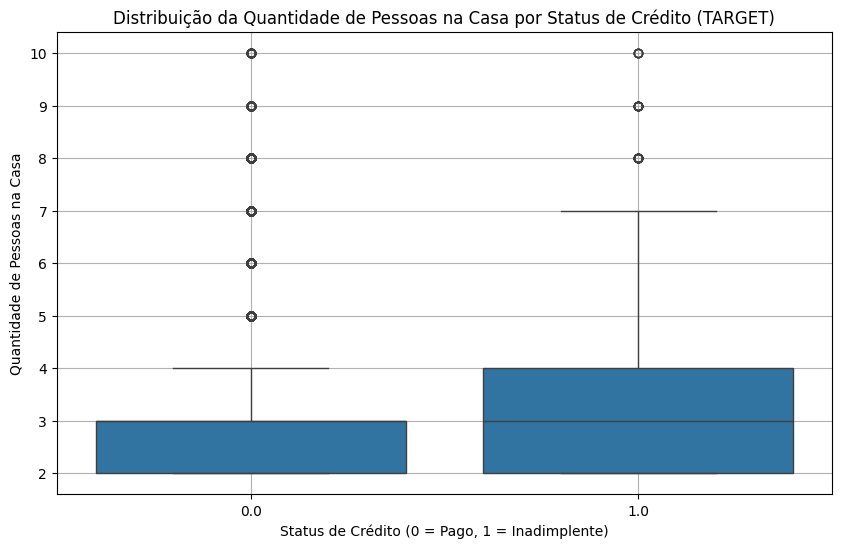

In [14]:
query("""
SELECT
  TARGET,
  COUNT(*) AS total_clients,
  AVG(QTDPESSOASCASA) AS avg_household_size,
  MIN(QTDPESSOASCASA) AS min_household_size,
  MAX(QTDPESSOASCASA) AS max_household_size
FROM train
WHERE QTDPESSOASCASA IS NOT NULL
GROUP BY TARGET
ORDER BY TARGET
""")

household_target_data = spark.sql("""
SELECT
  TARGET,
  QTDPESSOASCASA
FROM train
WHERE QTDPESSOASCASA IS NOT NULL
""").toPandas()

plt.figure(figsize=(10,6))
sns.boxplot(x="TARGET", y="QTDPESSOASCASA", data=household_target_data)
plt.title('Distribuição da Quantidade de Pessoas na Casa por Status de Crédito (TARGET)')
plt.xlabel('Status de Crédito (0 = Pago, 1 = Inadimplente)')
plt.ylabel('Quantidade de Pessoas na Casa')
plt.grid(True)
plt.show()

## **Clientes que vivem em regiões mais jovens são mais propensos à inadimplência do que aqueles que vivem em regiões mais envelhecidas?**

+------+-------------+-----------------+-----------+-----------+
|TARGET|total_clients|      avg_age_cep|min_age_cep|max_age_cep|
+------+-------------+-----------------+-----------+-----------+
|   0.0|        61334|45.64339518048717|         25|         76|
|   1.0|         5162|45.51201084850833|         27|         72|
+------+-------------+-----------------+-----------+-----------+



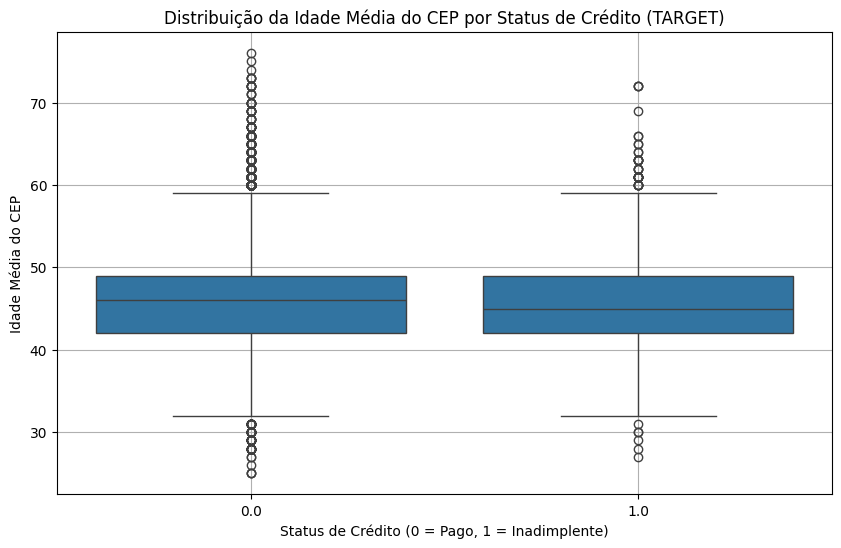

In [15]:
query("""
SELECT
  TARGET,
  COUNT(*) AS total_clients,
  AVG(IDADEMEDIACEP) AS avg_age_cep,
  MIN(IDADEMEDIACEP) AS min_age_cep,
  MAX(IDADEMEDIACEP) AS max_age_cep
FROM train
WHERE IDADEMEDIACEP IS NOT NULL
GROUP BY TARGET
ORDER BY TARGET
""")

cep_age_target_data = spark.sql("""
SELECT
  TARGET,
  IDADEMEDIACEP
FROM train
WHERE IDADEMEDIACEP IS NOT NULL
""").toPandas()

plt.figure(figsize=(10,6))
sns.boxplot(x="TARGET", y="IDADEMEDIACEP", data=cep_age_target_data)
plt.title('Distribuição da Idade Média do CEP por Status de Crédito (TARGET)')
plt.xlabel('Status de Crédito (0 = Pago, 1 = Inadimplente)')
plt.ylabel('Idade Média do CEP')
plt.grid(True)
plt.show()

## **Clientes que vivem em bairros de maior renda média são mais resilientes financeiramente, apresentando menos inadimplência?**

+------+-------------+-----------------+--------------+--------------+
|TARGET|total_clients|   avg_income_cep|min_income_cep|max_income_cep|
+------+-------------+-----------------+--------------+--------------+
|   0.0|        61334|2642.961228682297|           852|         11442|
|   1.0|         5162|2531.950019372336|           866|         10635|
+------+-------------+-----------------+--------------+--------------+



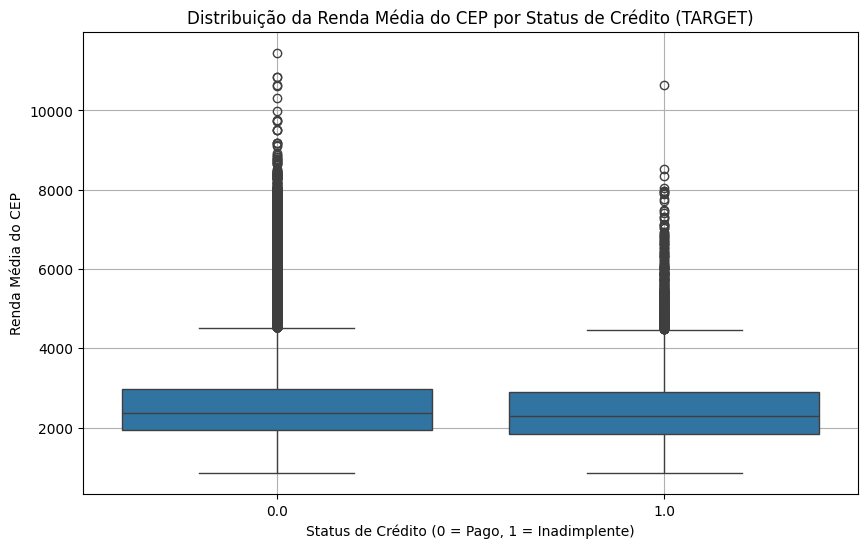

In [16]:
query("""
SELECT
  TARGET,
  COUNT(*) AS total_clients,
  AVG(MEDIARENDACEP) AS avg_income_cep,
  MIN(MEDIARENDACEP) AS min_income_cep,
  MAX(MEDIARENDACEP) AS max_income_cep
FROM train
WHERE MEDIARENDACEP IS NOT NULL
GROUP BY TARGET
ORDER BY TARGET
""")

cep_income_target_data = spark.sql("""
SELECT
  TARGET,
  MEDIARENDACEP
FROM train
WHERE MEDIARENDACEP IS NOT NULL
""").toPandas()

plt.figure(figsize=(10,6))
sns.boxplot(x="TARGET", y="MEDIARENDACEP", data=cep_income_target_data)
plt.title('Distribuição da Renda Média do CEP por Status de Crédito (TARGET)')
plt.xlabel('Status de Crédito (0 = Pago, 1 = Inadimplente)')
plt.ylabel('Renda Média do CEP')
plt.grid(True)
plt.show()

## **Trabalhar em empresas de grande porte reduz o risco de inadimplência em comparação a trabalhar em empresas menores?**

+------+---------------+-------------+
|TARGET|PORTEEMPREGADOR|total_clients|
+------+---------------+-------------+
|   0.0|              0|        52705|
|   1.0|              0|         5626|
|   0.0|              1|         9741|
|   1.0|              1|         1025|
|   0.0|              2|         6272|
|   1.0|              2|          621|
|   0.0|              3|         7634|
|   1.0|              3|          805|
|   0.0|              4|         6073|
|   1.0|              4|          385|
+------+---------------+-------------+



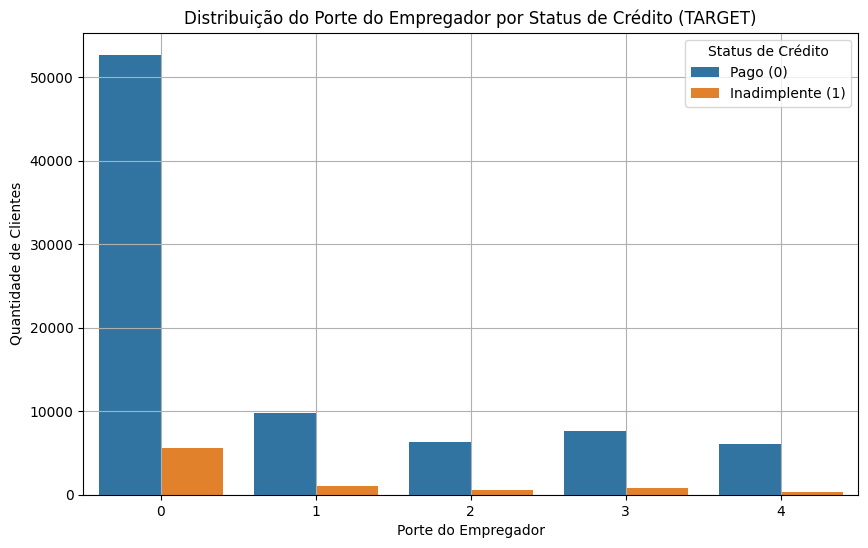

In [17]:
query("""
SELECT
  TARGET,
  PORTEEMPREGADOR,
  COUNT(*) AS total_clients
FROM train
WHERE PORTEEMPREGADOR IS NOT NULL
GROUP BY TARGET, PORTEEMPREGADOR
ORDER BY PORTEEMPREGADOR, TARGET
""")

employer_size_target_data = spark.sql("""
SELECT
  TARGET,
  PORTEEMPREGADOR
FROM train
WHERE PORTEEMPREGADOR IS NOT NULL
""").toPandas()

plt.figure(figsize=(10,6))
sns.countplot(x="PORTEEMPREGADOR", hue="TARGET", data=employer_size_target_data)
plt.title('Distribuição do Porte do Empregador por Status de Crédito (TARGET)')
plt.xlabel('Porte do Empregador')
plt.ylabel('Quantidade de Clientes')
plt.grid(True)
plt.legend(title='Status de Crédito', labels=['Pago (0)', 'Inadimplente (1)'])
plt.show()

## **Clientes que são sócios de empresas apresentam menor risco de inadimplência do que clientes que não possuem participação societária?**

+------+------------+-------------+
|TARGET|SOCIOEMPRESA|total_clients|
+------+------------+-------------+
|   0.0|           0|        75226|
|   1.0|           0|         7948|
|   0.0|           1|         7199|
|   1.0|           1|          514|
+------+------------+-------------+



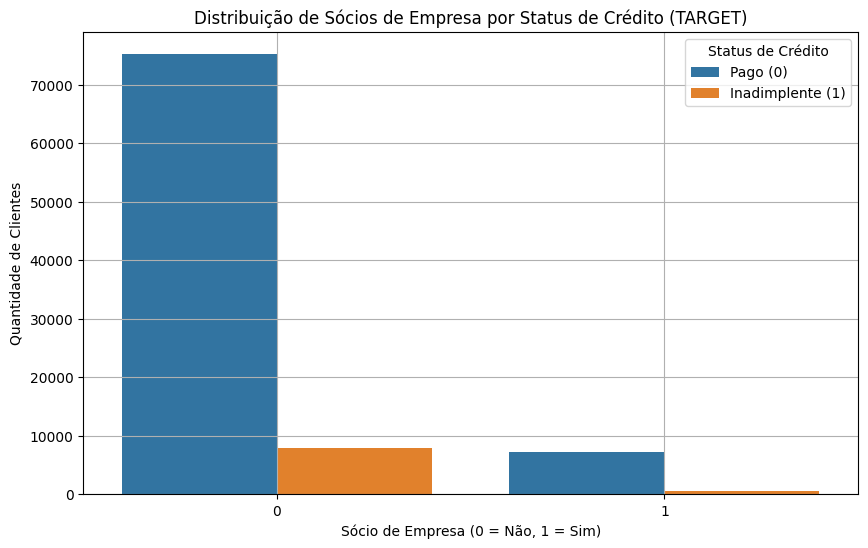

In [18]:
query("""
SELECT
  TARGET,
  SOCIOEMPRESA,
  COUNT(*) AS total_clients
FROM train
WHERE SOCIOEMPRESA IS NOT NULL
GROUP BY TARGET, SOCIOEMPRESA
ORDER BY SOCIOEMPRESA, TARGET
""")

socio_empresa_target_data = spark.sql("""
SELECT
  TARGET,
  SOCIOEMPRESA
FROM train
WHERE SOCIOEMPRESA IS NOT NULL
""").toPandas()

plt.figure(figsize=(10,6))
sns.countplot(x="SOCIOEMPRESA", hue="TARGET", data=socio_empresa_target_data)
plt.title('Distribuição de Sócios de Empresa por Status de Crédito (TARGET)')
plt.xlabel('Sócio de Empresa (0 = Não, 1 = Sim)')
plt.ylabel('Quantidade de Clientes')
plt.grid(True)
plt.legend(title='Status de Crédito', labels=['Pago (0)', 'Inadimplente (1)'])
plt.show()

## **Ser funcionário público está associado a menor risco de inadimplência em comparação a trabalhadores do setor privado?**

+------+------------------+-------------+
|TARGET|FUNCIONARIOPUBLICO|total_clients|
+------+------------------+-------------+
|   0.0|                 0|        74563|
|   1.0|                 0|         8002|
|   0.0|                 1|         7862|
|   1.0|                 1|          460|
+------+------------------+-------------+



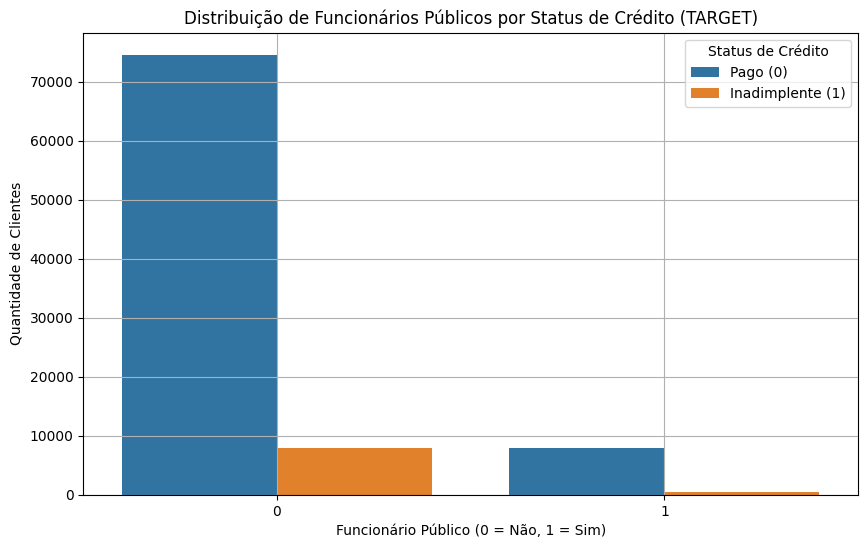

In [19]:
query("""
SELECT
  TARGET,
  FUNCIONARIOPUBLICO,
  COUNT(*) AS total_clients
FROM train
WHERE FUNCIONARIOPUBLICO IS NOT NULL
GROUP BY TARGET, FUNCIONARIOPUBLICO
ORDER BY FUNCIONARIOPUBLICO, TARGET
""")

public_employee_target_data = spark.sql("""
SELECT
  TARGET,
  FUNCIONARIOPUBLICO
FROM train
WHERE FUNCIONARIOPUBLICO IS NOT NULL
""").toPandas()

plt.figure(figsize=(10,6))
sns.countplot(x="FUNCIONARIOPUBLICO", hue="TARGET", data=public_employee_target_data)
plt.title('Distribuição de Funcionários Públicos por Status de Crédito (TARGET)')
plt.xlabel('Funcionário Público (0 = Não, 1 = Sim)')
plt.ylabel('Quantidade de Clientes')
plt.grid(True)
plt.legend(title='Status de Crédito', labels=['Pago (0)', 'Inadimplente (1)'])
plt.show()

## **Clientes que participam do programa Bolsa Família apresentam maior risco de inadimplência?**

+------+------------+-------------+
|TARGET|BOLSAFAMILIA|total_clients|
+------+------------+-------------+
|   0.0|           0|        79235|
|   1.0|           0|         7967|
|   0.0|           1|         3190|
|   1.0|           1|          495|
+------+------------+-------------+



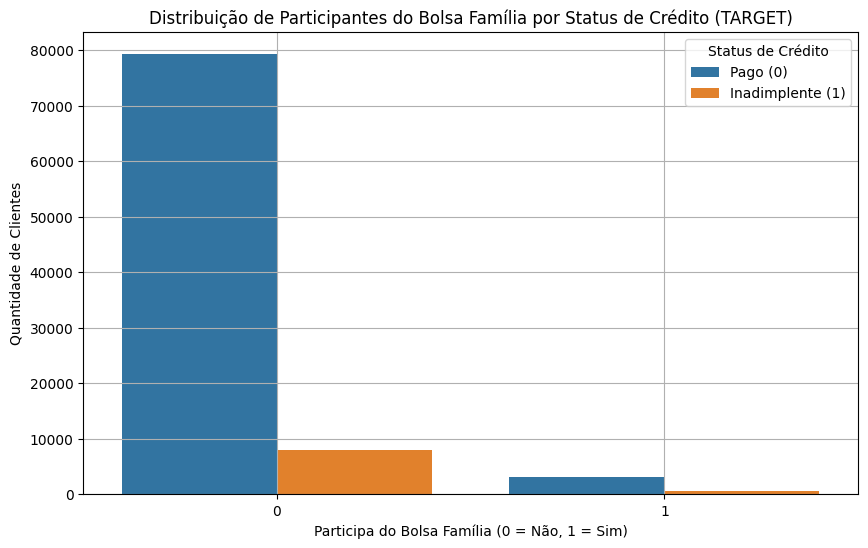

In [20]:
query("""
SELECT
  TARGET,
  BOLSAFAMILIA,
  COUNT(*) AS total_clients
FROM train
WHERE BOLSAFAMILIA IS NOT NULL
GROUP BY TARGET, BOLSAFAMILIA
ORDER BY BOLSAFAMILIA, TARGET
""")

bolsa_familia_target_data = spark.sql("""
SELECT
  TARGET,
  BOLSAFAMILIA
FROM train
WHERE BOLSAFAMILIA IS NOT NULL
""").toPandas()

plt.figure(figsize=(10,6))
sns.countplot(x="BOLSAFAMILIA", hue="TARGET", data=bolsa_familia_target_data)
plt.title('Distribuição de Participantes do Bolsa Família por Status de Crédito (TARGET)')
plt.xlabel('Participa do Bolsa Família (0 = Não, 1 = Sim)')
plt.ylabel('Quantidade de Clientes')
plt.grid(True)
plt.legend(title='Status de Crédito', labels=['Pago (0)', 'Inadimplente (1)'])
plt.show()

## **Clientes que moram mais longe do centro da cidade têm maior risco de inadimplência?**

+------+------------------------+------------+------------+-------------+
|TARGET|avg_distance_city_center|min_distance|max_distance|total_clients|
+------+------------------------+------------+------------+-------------+
|   0.0|      4012.9553327670933|           0|       49716|        65932|
|   1.0|       4280.373161430906|           0|       48999|         5507|
+------+------------------------+------------+------------+-------------+



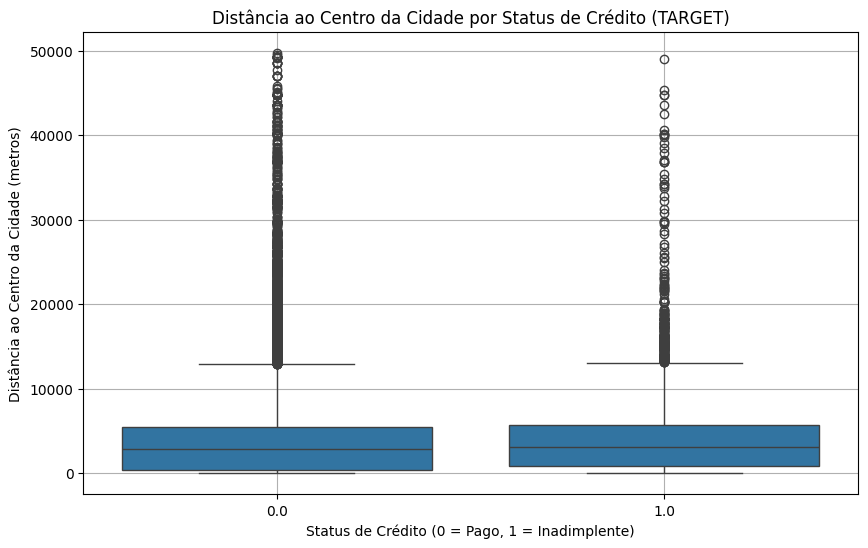

In [21]:
query("""
SELECT
  TARGET,
  AVG(DISTCENTROCIDADE) AS avg_distance_city_center,
  MIN(DISTCENTROCIDADE) AS min_distance,
  MAX(DISTCENTROCIDADE) AS max_distance,
  COUNT(*) AS total_clients
FROM train
WHERE DISTCENTROCIDADE IS NOT NULL
GROUP BY TARGET
ORDER BY TARGET
""")

distance_city_target_data = spark.sql("""
SELECT
  TARGET,
  DISTCENTROCIDADE
FROM train
WHERE DISTCENTROCIDADE IS NOT NULL
""").toPandas()

plt.figure(figsize=(10,6))
sns.boxplot(x="TARGET", y="DISTCENTROCIDADE", data=distance_city_target_data)
plt.title('Distância ao Centro da Cidade por Status de Crédito (TARGET)')
plt.xlabel('Status de Crédito (0 = Pago, 1 = Inadimplente)')
plt.ylabel('Distância ao Centro da Cidade (metros)')
plt.grid(True)
plt.show()

## **Clientes que vivem mais próximos a zonas de risco apresentam maior probabilidade de inadimplência?**

+------+----------------------+------------+------------+-------------+
|TARGET|avg_distance_risk_zone|min_distance|max_distance|total_clients|
+------+----------------------+------------+------------+-------------+
|   0.0|     79307.84397561123|           0|      842292|        65932|
|   1.0|      78256.1603413837|           0|      842292|         5507|
+------+----------------------+------------+------------+-------------+



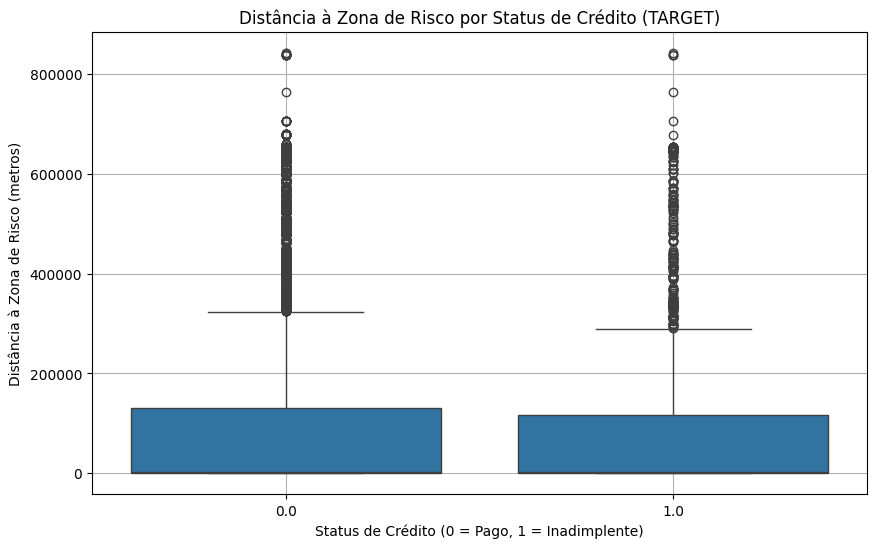

In [22]:
query("""
SELECT
  TARGET,
  AVG(DISTZONARISCO) AS avg_distance_risk_zone,
  MIN(DISTZONARISCO) AS min_distance,
  MAX(DISTZONARISCO) AS max_distance,
  COUNT(*) AS total_clients
FROM train
WHERE DISTZONARISCO IS NOT NULL
GROUP BY TARGET
ORDER BY TARGET
""")

risk_zone_target_data = spark.sql("""
SELECT
  TARGET,
  DISTZONARISCO
FROM train
WHERE DISTZONARISCO IS NOT NULL
""").toPandas()

plt.figure(figsize=(10,6))
sns.boxplot(x="TARGET", y="DISTZONARISCO", data=risk_zone_target_data)
plt.title('Distância à Zona de Risco por Status de Crédito (TARGET)')
plt.xlabel('Status de Crédito (0 = Pago, 1 = Inadimplente)')
plt.ylabel('Distância à Zona de Risco (metros)')
plt.grid(True)
plt.show()

## **Clientes com maior quantidade de celulares cadastrados apresentam menor risco de inadimplência?**

+------+------------------+--------------+--------------+-------------+
|TARGET|    avg_cellphones|min_cellphones|max_cellphones|total_clients|
+------+------------------+--------------+--------------+-------------+
|   0.0|0.9903548680618744|             0|            42|        82425|
|   1.0|0.6886078941148664|             0|            10|         8462|
+------+------------------+--------------+--------------+-------------+



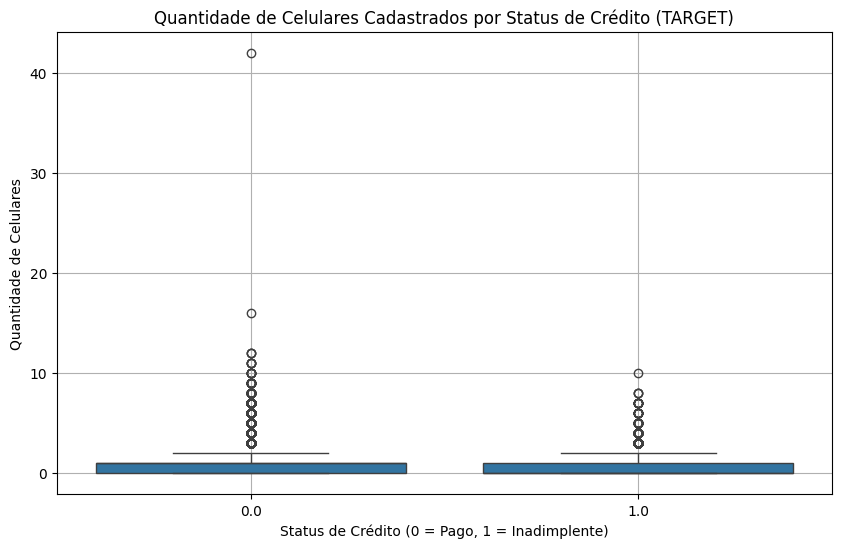

In [26]:
query("""
SELECT
  TARGET,
  AVG(QTDCELULAR) AS avg_cellphones,
  MIN(QTDCELULAR) AS min_cellphones,
  MAX(QTDCELULAR) AS max_cellphones,
  COUNT(*) AS total_clients
FROM train
WHERE QTDCELULAR IS NOT NULL
GROUP BY TARGET
ORDER BY TARGET
""")

cellphones_target_data = spark.sql("""
SELECT
  TARGET,
  QTDCELULAR
FROM train
WHERE QTDCELULAR IS NOT NULL
""").toPandas()

plt.figure(figsize=(10,6))
sns.boxplot(x="TARGET", y="QTDCELULAR", data=cellphones_target_data)
plt.title('Quantidade de Celulares Cadastrados por Status de Crédito (TARGET)')
plt.xlabel('Status de Crédito (0 = Pago, 1 = Inadimplente)')
plt.ylabel('Quantidade de Celulares')
plt.grid(True)
plt.show()

## **Ter um telefone fixo cadastrado está associado a menor risco de inadimplência?**

+------+------------------+-------------+-------------+-------------+
|TARGET|     avg_landlines|min_landlines|max_landlines|total_clients|
+------+------------------+-------------+-------------+-------------+
|   0.0|1.4822687291477101|            0|          110|        82425|
|   1.0|1.1236114393760341|            0|           10|         8462|
+------+------------------+-------------+-------------+-------------+



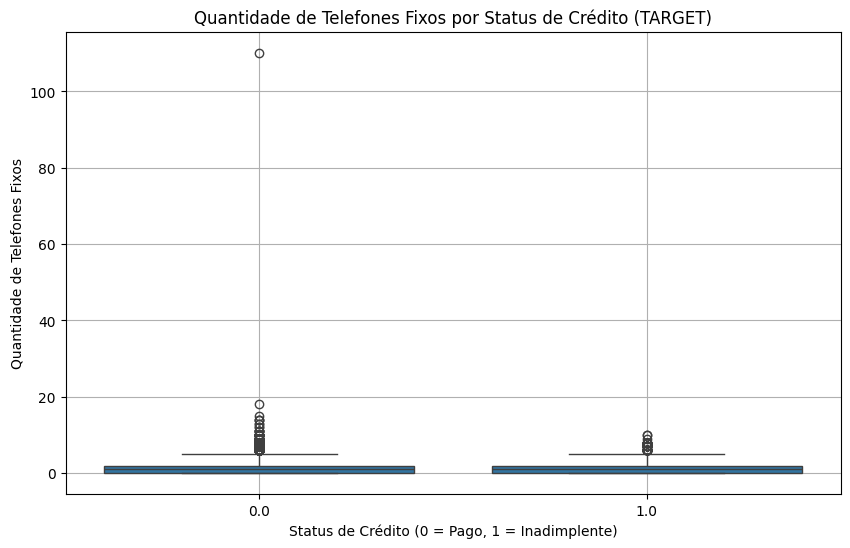

In [28]:
query("""
SELECT
  TARGET,
  AVG(QTDFONEFIXO) AS avg_landlines,
  MIN(QTDFONEFIXO) AS min_landlines,
  MAX(QTDFONEFIXO) AS max_landlines,
  COUNT(*) AS total_clients
FROM train
WHERE QTDFONEFIXO IS NOT NULL
GROUP BY TARGET
ORDER BY TARGET
""")

landlines_target_data = spark.sql("""
SELECT
  TARGET,
  QTDFONEFIXO
FROM train
WHERE QTDFONEFIXO IS NOT NULL
""").toPandas()

plt.figure(figsize=(10,6))
sns.boxplot(x="TARGET", y="QTDFONEFIXO", data=landlines_target_data)
plt.title('Quantidade de Telefones Fixos por Status de Crédito (TARGET)')
plt.xlabel('Status de Crédito (0 = Pago, 1 = Inadimplente)')
plt.ylabel('Quantidade de Telefones Fixos')
plt.grid(True)
plt.show()

## **Clientes com maior estabilidade no emprego (INDICEEMPREGO) têm menor probabilidade de inadimplência?**

+------+------------------------+------------------------+------------------------+-------------+
|TARGET|avg_employment_stability|min_employment_stability|max_employment_stability|total_clients|
+------+------------------------+------------------------+------------------------+-------------+
|   0.0|      1.5529026387625113|                       0|                       6|        82425|
|   1.0|      0.9987000709052234|                       0|                       6|         8462|
+------+------------------------+------------------------+------------------------+-------------+



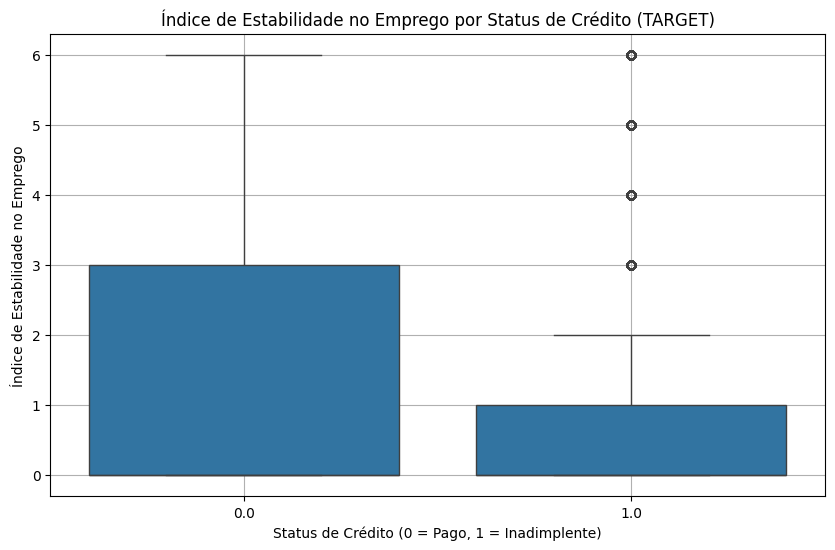

In [29]:
query("""
SELECT
  TARGET,
  AVG(INDICEEMPREGO) AS avg_employment_stability,
  MIN(INDICEEMPREGO) AS min_employment_stability,
  MAX(INDICEEMPREGO) AS max_employment_stability,
  COUNT(*) AS total_clients
FROM train
WHERE INDICEEMPREGO IS NOT NULL
GROUP BY TARGET
ORDER BY TARGET
""")

employment_index_target_data = spark.sql("""
SELECT
  TARGET,
  INDICEEMPREGO
FROM train
WHERE INDICEEMPREGO IS NOT NULL
""").toPandas()

plt.figure(figsize=(10,6))
sns.boxplot(x="TARGET", y="INDICEEMPREGO", data=employment_index_target_data)
plt.title('Índice de Estabilidade no Emprego por Status de Crédito (TARGET)')
plt.xlabel('Status de Crédito (0 = Pago, 1 = Inadimplente)')
plt.ylabel('Índice de Estabilidade no Emprego')
plt.grid(True)
plt.show()

## **Clientes com muitos endereços cadastrados são mais instáveis financeiramente e, portanto, mais propensos à inadimplência?**

+------+------------------+-------------+-------------+-------------+
|TARGET|     avg_addresses|min_addresses|max_addresses|total_clients|
+------+------------------+-------------+-------------+-------------+
|   0.0|  1.40877161055505|            0|           48|        82425|
|   1.0|1.1190025998581896|            0|           24|         8462|
+------+------------------+-------------+-------------+-------------+



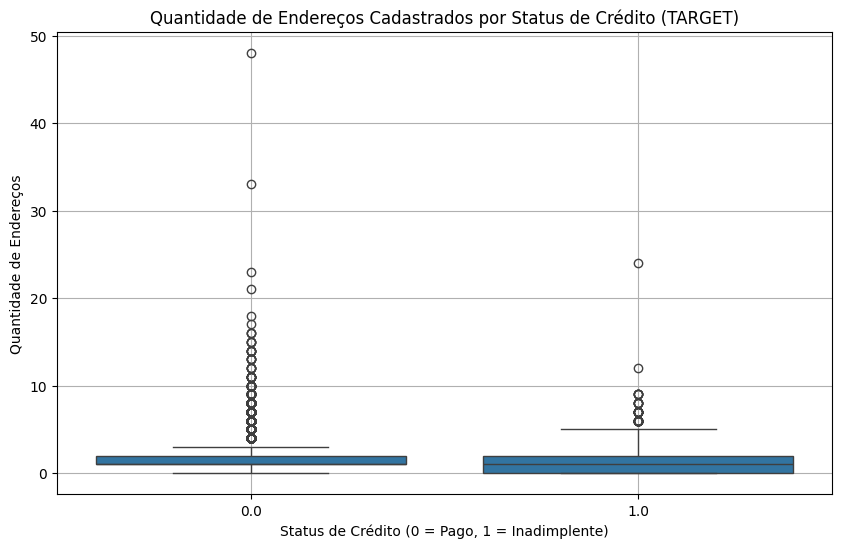

In [32]:
query("""
SELECT
  TARGET,
  AVG(QTDENDERECO) AS avg_addresses,
  MIN(QTDENDERECO) AS min_addresses,
  MAX(QTDENDERECO) AS max_addresses,
  COUNT(*) AS total_clients
FROM train
WHERE QTDENDERECO IS NOT NULL
GROUP BY TARGET
ORDER BY TARGET
""")

addresses_target_data = spark.sql("""
SELECT
  TARGET,
  QTDENDERECO
FROM train
WHERE QTDENDERECO IS NOT NULL
""").toPandas()

plt.figure(figsize=(10,6))
sns.boxplot(x="TARGET", y="QTDENDERECO", data=addresses_target_data)
plt.title('Quantidade de Endereços Cadastrados por Status de Crédito (TARGET)')
plt.xlabel('Status de Crédito (0 = Pago, 1 = Inadimplente)')
plt.ylabel('Quantidade de Endereços')
plt.grid(True)
plt.show()

## **Clientes que vivem em famílias com maior renda total (SOMARENDACASA) apresentam menor probabilidade de inadimplência?**

+------+--------------------+--------------------+--------------------+-------------+
|TARGET|avg_household_income|min_household_income|max_household_income|total_clients|
+------+--------------------+--------------------+--------------------+-------------+
|   0.0|   8380.894500455417|                 800|               92200|        31839|
|   1.0|   7092.130829015544|                 800|               83200|         3088|
+------+--------------------+--------------------+--------------------+-------------+



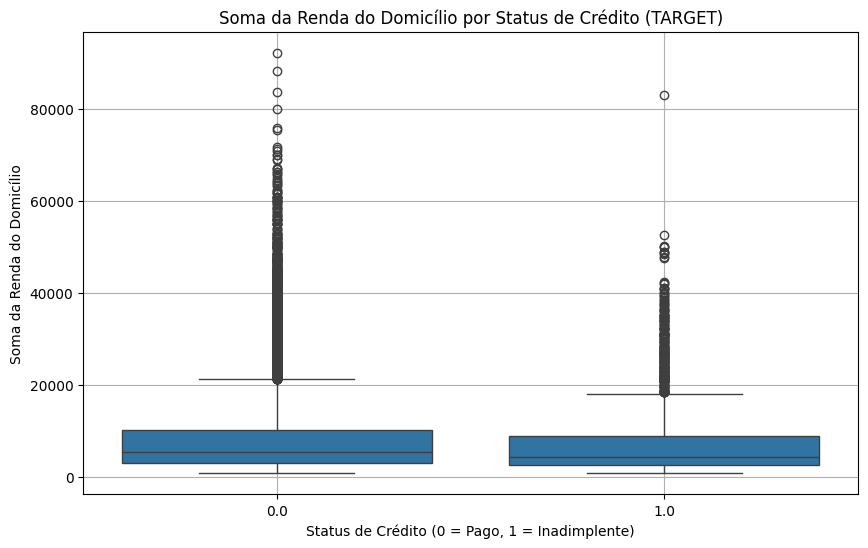

In [34]:
query("""
SELECT
  TARGET,
  AVG(SOMARENDACASA) AS avg_household_income,
  MIN(SOMARENDACASA) AS min_household_income,
  MAX(SOMARENDACASA) AS max_household_income,
  COUNT(*) AS total_clients
FROM train
WHERE SOMARENDACASA IS NOT NULL
GROUP BY TARGET
ORDER BY TARGET
""")

household_income_target_data = spark.sql("""
SELECT
  TARGET,
  SOMARENDACASA
FROM train
WHERE SOMARENDACASA IS NOT NULL
""").toPandas()

plt.figure(figsize=(10,6))
sns.boxplot(x="TARGET", y="SOMARENDACASA", data=household_income_target_data)
plt.title('Soma da Renda do Domicílio por Status de Crédito (TARGET)')
plt.xlabel('Status de Crédito (0 = Pago, 1 = Inadimplente)')
plt.ylabel('Soma da Renda do Domicílio')
plt.grid(True)
plt.show()

# **Análises Multivariadas em Relação ao Risco de Default**

## **Entre clientes com alta renda (ESTIMATIVARENDA), aqueles que possuem telefone fixo (QTDFONEFIXO) demonstram menor inadimplência, sinalizando maior estabilidade econômica tradicional?**

+-----------+-----------------+------+-----+
|faixa_renda|  possui_fonefixo|TARGET|total|
+-----------+-----------------+------+-----+
|       Alta|Com Telefone Fixo|   0.0|11281|
|       Alta|Com Telefone Fixo|   1.0|  602|
|       Alta|Sem Telefone Fixo|   0.0|  558|
|       Alta|Sem Telefone Fixo|   1.0|   41|
|      Baixa|Com Telefone Fixo|   0.0|30348|
|      Baixa|Com Telefone Fixo|   1.0| 3166|
|      Baixa|Sem Telefone Fixo|   0.0|20952|
|      Baixa|Sem Telefone Fixo|   1.0| 3276|
|      Média|Com Telefone Fixo|   0.0|16928|
|      Média|Com Telefone Fixo|   1.0| 1153|
|      Média|Sem Telefone Fixo|   0.0| 2358|
|      Média|Sem Telefone Fixo|   1.0|  224|
+-----------+-----------------+------+-----+



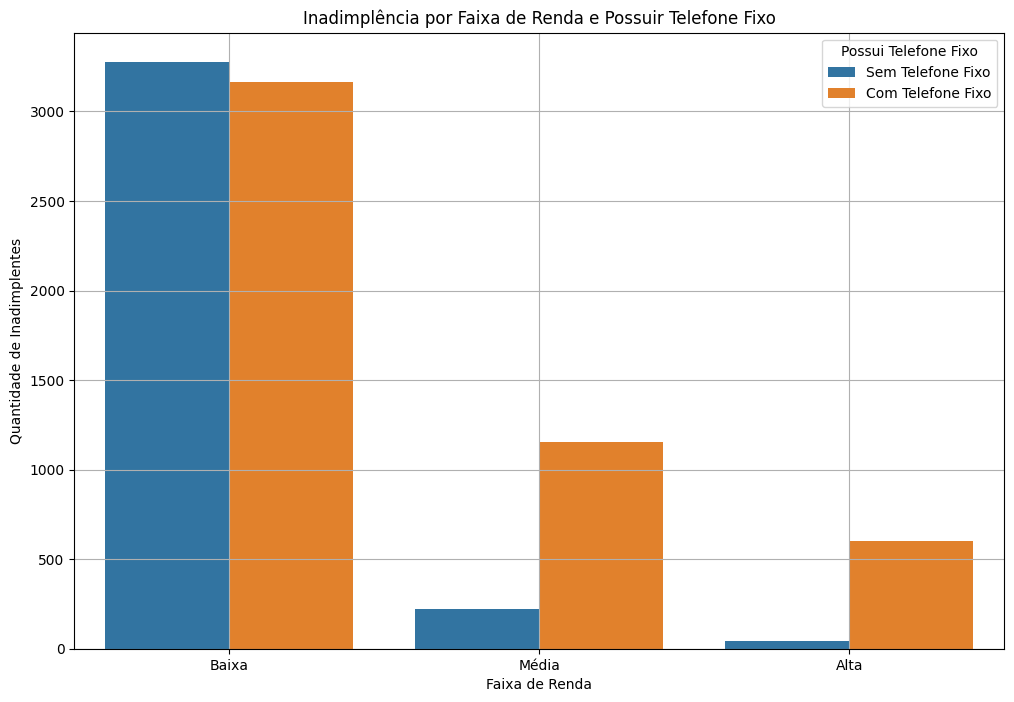

In [37]:
query("""
SELECT
  CASE
    WHEN ESTIMATIVARENDA < 2000 THEN 'Baixa'
    WHEN ESTIMATIVARENDA BETWEEN 2000 AND 6000 THEN 'Média'
    ELSE 'Alta'
  END AS faixa_renda,
  CASE
    WHEN QTDFONEFIXO = 0 THEN 'Sem Telefone Fixo'
    ELSE 'Com Telefone Fixo'
  END AS possui_fonefixo,
  TARGET,
  COUNT(*) AS total
FROM train
WHERE ESTIMATIVARENDA IS NOT NULL AND QTDFONEFIXO IS NOT NULL
GROUP BY faixa_renda, possui_fonefixo, TARGET
ORDER BY faixa_renda, possui_fonefixo, TARGET
""")

phone_income_target_data = spark.sql("""
SELECT
  CASE
    WHEN ESTIMATIVARENDA < 2000 THEN 'Baixa'
    WHEN ESTIMATIVARENDA BETWEEN 2000 AND 6000 THEN 'Média'
    ELSE 'Alta'
  END AS faixa_renda,
  CASE
    WHEN QTDFONEFIXO = 0 THEN 'Sem Telefone Fixo'
    ELSE 'Com Telefone Fixo'
  END AS possui_fonefixo,
  TARGET
FROM train
WHERE ESTIMATIVARENDA IS NOT NULL AND QTDFONEFIXO IS NOT NULL
""").toPandas()

plt.figure(figsize=(12,8))
sns.countplot(x="faixa_renda", hue="possui_fonefixo", data=phone_income_target_data[phone_income_target_data["TARGET"] == 1])
plt.title('Inadimplência por Faixa de Renda e Possuir Telefone Fixo')
plt.xlabel('Faixa de Renda')
plt.ylabel('Quantidade de Inadimplentes')
plt.legend(title='Possui Telefone Fixo')
plt.grid(True)
plt.show()

## **Famílias que recebem Bolsa Família e têm uma média de idade mais jovem (MEDIAIDADECASA) são mais propensas à inadimplência do que famílias mais velhas?**

+----------------+--------------------+------+-----+
|faixa_idade_casa|        status_bolsa|TARGET|total|
+----------------+--------------------+------+-----+
|    Adulto Jovem|Não Recebe Bolsa ...|   0.0|21443|
|    Adulto Jovem|Não Recebe Bolsa ...|   1.0| 2064|
|    Adulto Jovem|Recebe Bolsa Família|   0.0|  925|
|    Adulto Jovem|Recebe Bolsa Família|   1.0|  148|
|   Adulto Maduro|Não Recebe Bolsa ...|   0.0| 5742|
|   Adulto Maduro|Não Recebe Bolsa ...|   1.0|  406|
|   Adulto Maduro|Recebe Bolsa Família|   0.0|  160|
|   Adulto Maduro|Recebe Bolsa Família|   1.0|   11|
|     Muito Jovem|Não Recebe Bolsa ...|   0.0| 3330|
|     Muito Jovem|Não Recebe Bolsa ...|   1.0|  411|
|     Muito Jovem|Recebe Bolsa Família|   0.0|  232|
|     Muito Jovem|Recebe Bolsa Família|   1.0|   45|
+----------------+--------------------+------+-----+



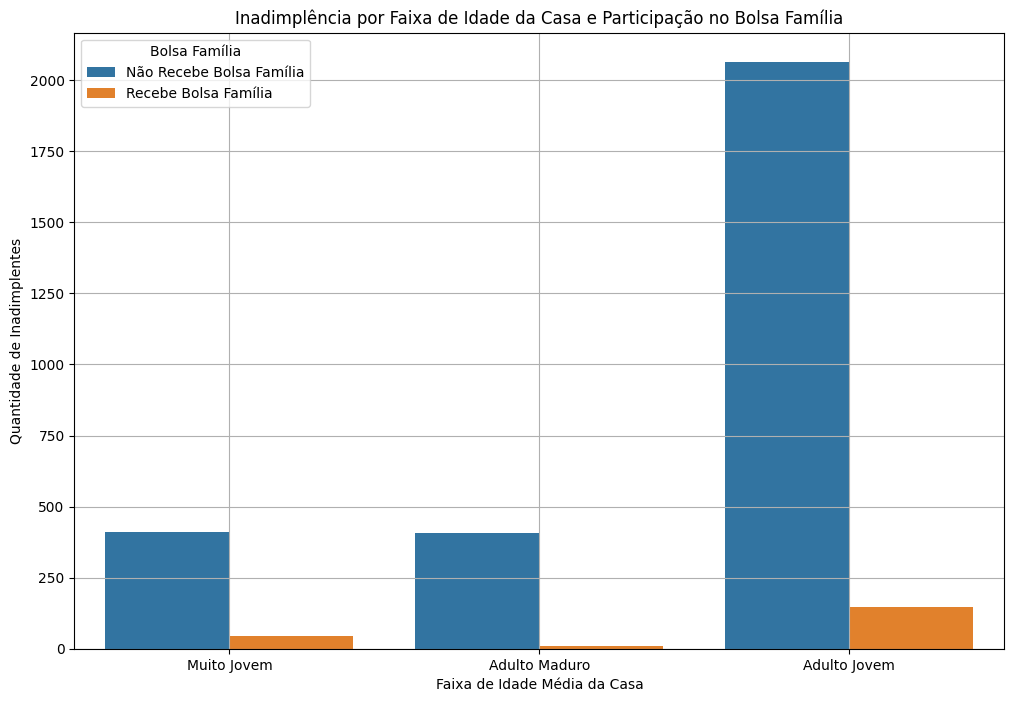

In [38]:
query("""
SELECT
  CASE
    WHEN MEDIAIDADECASA < 25 THEN 'Muito Jovem'
    WHEN MEDIAIDADECASA BETWEEN 25 AND 45 THEN 'Adulto Jovem'
    ELSE 'Adulto Maduro'
  END AS faixa_idade_casa,
  CASE
    WHEN BOLSAFAMILIA = 1 THEN 'Recebe Bolsa Família'
    ELSE 'Não Recebe Bolsa Família'
  END AS status_bolsa,
  TARGET,
  COUNT(*) AS total
FROM train
WHERE MEDIAIDADECASA IS NOT NULL AND BOLSAFAMILIA IS NOT NULL
GROUP BY faixa_idade_casa, status_bolsa, TARGET
ORDER BY faixa_idade_casa, status_bolsa, TARGET
""")

bolsa_idade_target_data = spark.sql("""
SELECT
  CASE
    WHEN MEDIAIDADECASA < 25 THEN 'Muito Jovem'
    WHEN MEDIAIDADECASA BETWEEN 25 AND 45 THEN 'Adulto Jovem'
    ELSE 'Adulto Maduro'
  END AS faixa_idade_casa,
  CASE
    WHEN BOLSAFAMILIA = 1 THEN 'Recebe Bolsa Família'
    ELSE 'Não Recebe Bolsa Família'
  END AS status_bolsa,
  TARGET
FROM train
WHERE MEDIAIDADECASA IS NOT NULL AND BOLSAFAMILIA IS NOT NULL
""").toPandas()

plt.figure(figsize=(12,8))
sns.countplot(x="faixa_idade_casa", hue="status_bolsa", data=bolsa_idade_target_data[bolsa_idade_target_data["TARGET"] == 1])
plt.title('Inadimplência por Faixa de Idade da Casa e Participação no Bolsa Família')
plt.xlabel('Faixa de Idade Média da Casa')
plt.ylabel('Quantidade de Inadimplentes')
plt.legend(title='Bolsa Família')
plt.grid(True)
plt.show()

## **Clientes que vivem em regiões com maior proporção de mulheres (PERCENTFEMCEP) apresentam padrões de inadimplência diferentes, especialmente nas faixas de menor renda (ESTIMATIVARENDA)?**

+-----------+-----------------+------+-----+
|faixa_renda|perfil_genero_cep|TARGET|total|
+-----------+-----------------+------+-----+
|       Alta| Maioria Feminina|   0.0| 3492|
|       Alta| Maioria Feminina|   1.0|  195|
|       Alta|Maioria Masculina|   0.0| 7279|
|       Alta|Maioria Masculina|   1.0|  391|
|      Baixa| Maioria Feminina|   0.0| 9925|
|      Baixa| Maioria Feminina|   1.0| 1049|
|      Baixa|Maioria Masculina|   0.0|24017|
|      Baixa|Maioria Masculina|   1.0| 2405|
|      Média| Maioria Feminina|   0.0| 5167|
|      Média| Maioria Feminina|   1.0|  360|
|      Média|Maioria Masculina|   0.0|11454|
|      Média|Maioria Masculina|   1.0|  762|
+-----------+-----------------+------+-----+



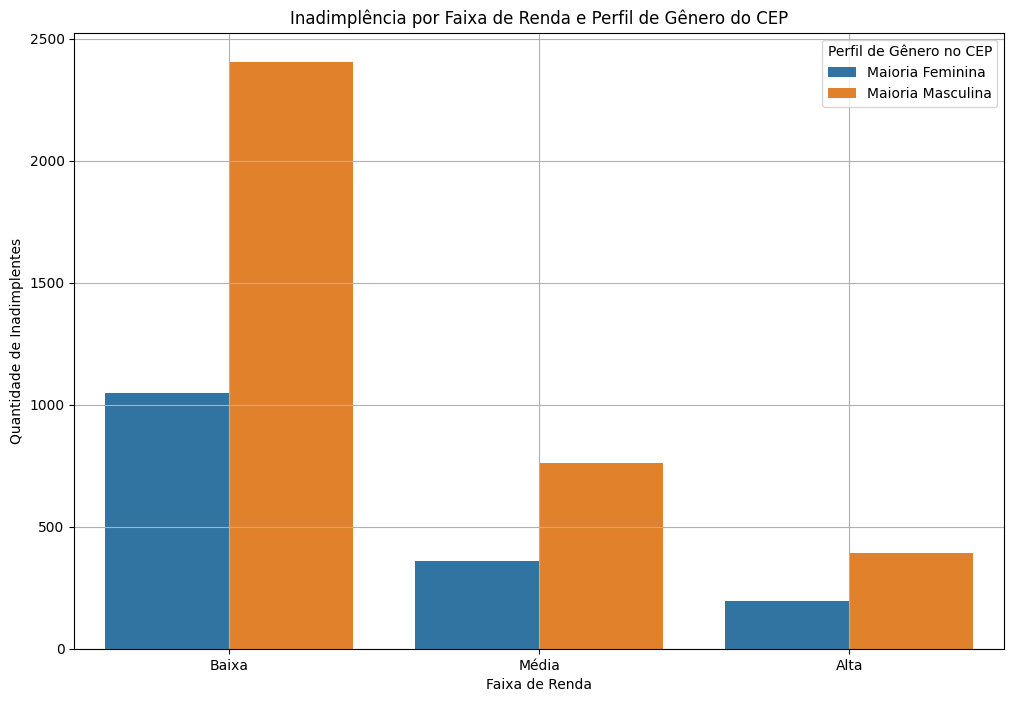

In [39]:
query("""
SELECT
  CASE
    WHEN ESTIMATIVARENDA < 2000 THEN 'Baixa'
    WHEN ESTIMATIVARENDA BETWEEN 2000 AND 6000 THEN 'Média'
    ELSE 'Alta'
  END AS faixa_renda,
  CASE
    WHEN PERCENTFEMCEP < 50 THEN 'Maioria Masculina'
    ELSE 'Maioria Feminina'
  END AS perfil_genero_cep,
  TARGET,
  COUNT(*) AS total
FROM train
WHERE ESTIMATIVARENDA IS NOT NULL AND PERCENTFEMCEP IS NOT NULL
GROUP BY faixa_renda, perfil_genero_cep, TARGET
ORDER BY faixa_renda, perfil_genero_cep, TARGET
""")

gender_income_target_data = spark.sql("""
SELECT
  CASE
    WHEN ESTIMATIVARENDA < 2000 THEN 'Baixa'
    WHEN ESTIMATIVARENDA BETWEEN 2000 AND 6000 THEN 'Média'
    ELSE 'Alta'
  END AS faixa_renda,
  CASE
    WHEN PERCENTFEMCEP < 50 THEN 'Maioria Masculina'
    ELSE 'Maioria Feminina'
  END AS perfil_genero_cep,
  TARGET
FROM train
WHERE ESTIMATIVARENDA IS NOT NULL AND PERCENTFEMCEP IS NOT NULL
""").toPandas()

plt.figure(figsize=(12,8))
sns.countplot(x="faixa_renda", hue="perfil_genero_cep", data=gender_income_target_data[gender_income_target_data["TARGET"] == 1])
plt.title('Inadimplência por Faixa de Renda e Perfil de Gênero do CEP')
plt.xlabel('Faixa de Renda')
plt.ylabel('Quantidade de Inadimplentes')
plt.legend(title='Perfil de Gênero no CEP')
plt.grid(True)
plt.show()

## **Clientes de renda média-baixa (ESTIMATIVARENDA) que moram em casas com mais pessoas (QTDPESSOASCASA) são mais propensos à inadimplência, sugerindo pressão financeira familiar?**

+-----------+-----------------+------+-----+
|faixa_renda|  tamanho_familia|TARGET|total|
+-----------+-----------------+------+-----+
|       Alta|    3 a 4 Pessoas|   0.0| 1991|
|       Alta|    3 a 4 Pessoas|   1.0|  103|
|       Alta|5 ou mais Pessoas|   0.0|  266|
|       Alta|5 ou mais Pessoas|   1.0|   20|
|       Alta|    Até 2 Pessoas|   0.0| 2480|
|       Alta|    Até 2 Pessoas|   1.0|  131|
|      Baixa|    3 a 4 Pessoas|   0.0| 8915|
|      Baixa|    3 a 4 Pessoas|   1.0| 1047|
|      Baixa|5 ou mais Pessoas|   0.0| 2279|
|      Baixa|5 ou mais Pessoas|   1.0|  358|
|      Baixa|    Até 2 Pessoas|   0.0| 7876|
|      Baixa|    Até 2 Pessoas|   1.0|  904|
|      Média|    3 a 4 Pessoas|   0.0| 3617|
|      Média|    3 a 4 Pessoas|   1.0|  270|
|      Média|5 ou mais Pessoas|   0.0|  640|
|      Média|5 ou mais Pessoas|   1.0|   45|
|      Média|    Até 2 Pessoas|   0.0| 3775|
|      Média|    Até 2 Pessoas|   1.0|  210|
+-----------+-----------------+------+-----+



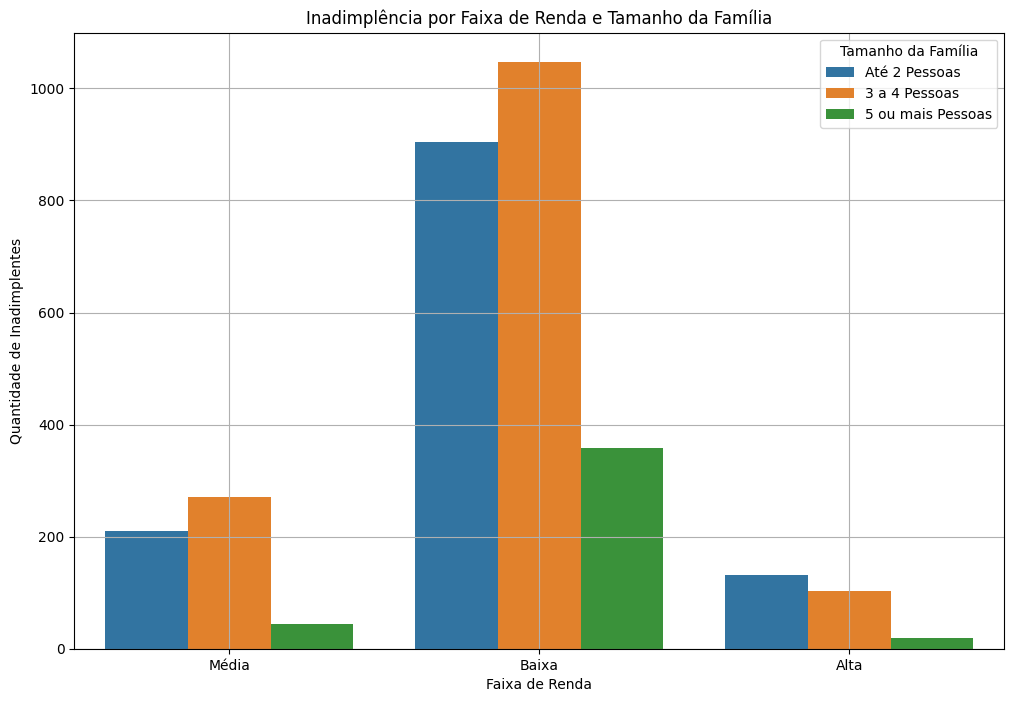

In [40]:
query("""
SELECT
  CASE
    WHEN ESTIMATIVARENDA < 2000 THEN 'Baixa'
    WHEN ESTIMATIVARENDA BETWEEN 2000 AND 6000 THEN 'Média'
    ELSE 'Alta'
  END AS faixa_renda,
  CASE
    WHEN QTDPESSOASCASA <= 2 THEN 'Até 2 Pessoas'
    WHEN QTDPESSOASCASA BETWEEN 3 AND 4 THEN '3 a 4 Pessoas'
    ELSE '5 ou mais Pessoas'
  END AS tamanho_familia,
  TARGET,
  COUNT(*) AS total
FROM train
WHERE ESTIMATIVARENDA IS NOT NULL AND QTDPESSOASCASA IS NOT NULL
GROUP BY faixa_renda, tamanho_familia, TARGET
ORDER BY faixa_renda, tamanho_familia, TARGET
""")

household_renda_target_data = spark.sql("""
SELECT
  CASE
    WHEN ESTIMATIVARENDA < 2000 THEN 'Baixa'
    WHEN ESTIMATIVARENDA BETWEEN 2000 AND 6000 THEN 'Média'
    ELSE 'Alta'
  END AS faixa_renda,
  CASE
    WHEN QTDPESSOASCASA <= 2 THEN 'Até 2 Pessoas'
    WHEN QTDPESSOASCASA BETWEEN 3 AND 4 THEN '3 a 4 Pessoas'
    ELSE '5 ou mais Pessoas'
  END AS tamanho_familia,
  TARGET
FROM train
WHERE ESTIMATIVARENDA IS NOT NULL AND QTDPESSOASCASA IS NOT NULL
""").toPandas()

plt.figure(figsize=(12,8))
sns.countplot(x="faixa_renda", hue="tamanho_familia", data=household_renda_target_data[household_renda_target_data["TARGET"] == 1])
plt.title('Inadimplência por Faixa de Renda e Tamanho da Família')
plt.xlabel('Faixa de Renda')
plt.ylabel('Quantidade de Inadimplentes')
plt.legend(title='Tamanho da Família')
plt.grid(True)
plt.show()

## **Clientes que vivem em zonas altamente urbanizadas mas com baixa renda média (MEDIARENDACEP) enfrentam maior risco de inadimplência devido a alta pressão de custo de vida e baixa capacidade de geração de renda?**

+----------------+-----------------+------+-----+
|       tipo_zona|  faixa_renda_cep|TARGET|total|
+----------------+-----------------+------+-----+
|Zona Semi-Urbana| Alta Renda Média|   0.0|   24|
|Zona Semi-Urbana| Alta Renda Média|   1.0|    1|
|Zona Semi-Urbana|Baixa Renda Média|   0.0| 1117|
|Zona Semi-Urbana|Baixa Renda Média|   1.0|   91|
|Zona Semi-Urbana|Média Renda Média|   0.0| 4147|
|Zona Semi-Urbana|Média Renda Média|   1.0|  294|
|     Zona Urbana| Alta Renda Média|   0.0|15050|
|     Zona Urbana| Alta Renda Média|   1.0| 1140|
|     Zona Urbana|Baixa Renda Média|   0.0| 3205|
|     Zona Urbana|Baixa Renda Média|   1.0|  394|
|     Zona Urbana|Média Renda Média|   0.0|37752|
|     Zona Urbana|Média Renda Média|   1.0| 3237|
+----------------+-----------------+------+-----+



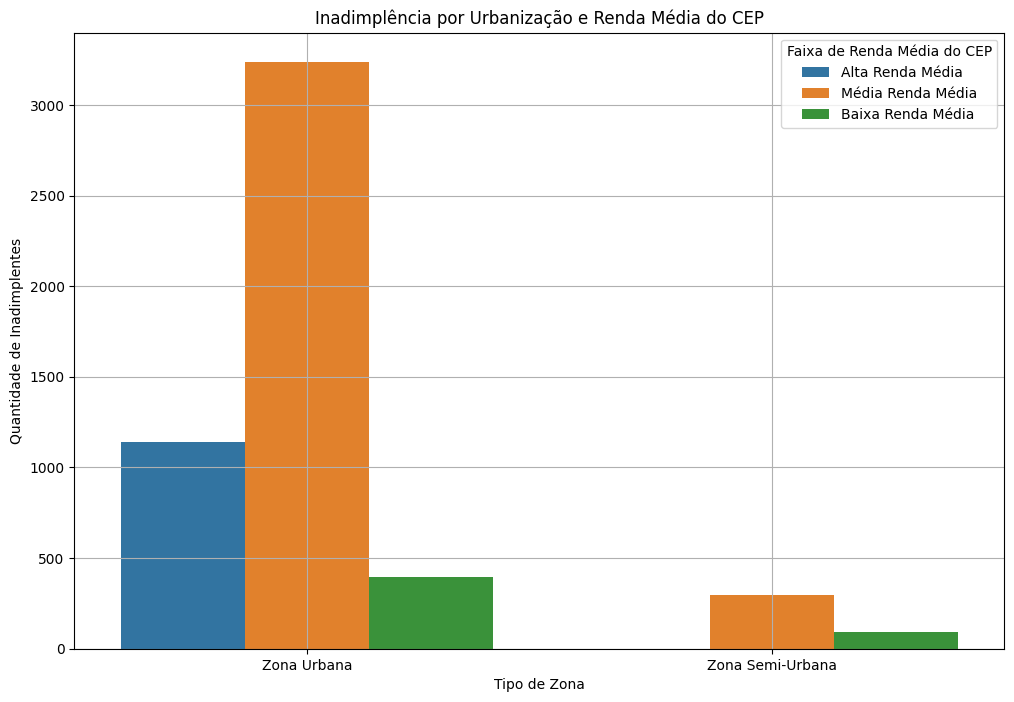

In [45]:
query("""
SELECT
  CASE
    WHEN PERCENTPOPZONAURBANA < 70 THEN 'Zona Semi-Urbana'
    ELSE 'Zona Urbana'
  END AS tipo_zona,
  CASE
    WHEN MEDIARENDACEP < 1500 THEN 'Baixa Renda Média'
    WHEN MEDIARENDACEP BETWEEN 1500 AND 3000 THEN 'Média Renda Média'
    ELSE 'Alta Renda Média'
  END AS faixa_renda_cep,
  TARGET,
  COUNT(*) AS total
FROM train
WHERE PERCENTPOPZONAURBANA IS NOT NULL AND MEDIARENDACEP IS NOT NULL
GROUP BY tipo_zona, faixa_renda_cep, TARGET
ORDER BY tipo_zona, faixa_renda_cep, TARGET
""")

urban_renda_target_data = spark.sql("""
SELECT
  CASE
    WHEN PERCENTPOPZONAURBANA < 70 THEN 'Zona Semi-Urbana'
    ELSE 'Zona Urbana'
  END AS tipo_zona,
  CASE
    WHEN MEDIARENDACEP < 1500 THEN 'Baixa Renda Média'
    WHEN MEDIARENDACEP BETWEEN 1500 AND 3000 THEN 'Média Renda Média'
    ELSE 'Alta Renda Média'
  END AS faixa_renda_cep,
  TARGET
FROM train
WHERE PERCENTPOPZONAURBANA IS NOT NULL AND MEDIARENDACEP IS NOT NULL
""").toPandas()

plt.figure(figsize=(12,8))
sns.countplot(x="tipo_zona", hue="faixa_renda_cep", data=urban_renda_target_data[urban_renda_target_data["TARGET"] == 1])
plt.title('Inadimplência por Urbanização e Renda Média do CEP')
plt.xlabel('Tipo de Zona')
plt.ylabel('Quantidade de Inadimplentes')
plt.legend(title='Faixa de Renda Média do CEP')
plt.grid(True)
plt.show()